In [1]:
import numpy as np 
import pandas as pd
import random

np.random.seed(0)
regions = ['West', 'East', 'North', 'South']

def dim_quote(rows=10000):
    '''
    Create a script to create a dimension table for sales quotes.

    Conditions:
    - 10,000 rows
    - Columns: 'quote_id', 'quote_date', 'customer_id', 'sales_rep_id', 'product_id', 'quantity', 'unit_price'
    - 'quote_id' column should be a unique identifier for each quote
    - 'quote_date' column should be a random date between 2024-01-01 and 2024-12-31
    - 'account_id' column should be a random integer between 1 and rows
    - 'region' column should be a random choice between regions 'West', 'East', 'North', 'South'
    - 'sales_rep_id' column should be a random integer between 1 and 10
    - 'product_id' column should be a random integer between 1 and 10
    - 'quantity' column should be pareto distribution with a mean of 500
    - 'status' column should be a random choice between 'won', 'lost' with probabilities 0.2 and 0.8 respectively
    - 'unit_price' will be created after referencing dim_product table since we want to utilize the 'list_price' column
    - 'margin' column is derived from a linear regression model with random noise
    - 'unit_price' column is derived from Margin of the product
    '''

    # Create a dictionary with the data
    data = {
        'quote_id': np.arange(1, rows+1),
        'quote_date': np.random.choice(pd.date_range(start='2024-01-01', end='2024-12-31'), rows),
        'account_id': np.random.randint(1, rows+1, rows),
        'sales_rep_id': np.random.randint(1, 11, rows),
        'region': np.random.choice(regions, rows),
        'product_id': np.random.randint(1, 11, rows),
        'quantity': np.random.pareto(a=3, size=rows) * 500,
        'status': np.random.choice(['won', 'lost'], rows, p=[0.2, 0.8])
    }

    # Create the DataFrame
    df = pd.DataFrame(data)

    # Round the 'quantity' column to the nearest integer
    df['quantity'] = df['quantity'].round().astype(int)

    # Load the dim_product table
    dim_product = pd.read_csv('data/dim_product.csv')

    # Merge the dim_product table with the df DataFrame
    df = pd.merge(df, dim_product[['product_id', 'list_price']], on='product_id', how='left')

    # Create the 'unit_price' column
    df['unit_price'] = df['list_price']

    # Create random options for the slope
    bias = (np.random.uniform(0.6, 0.9, size=5)).tolist()

    # Create the 'margin' column using custom function
    df['margin'] = df.groupby('product_id').apply(margin)['margin'].values
    
    # assign a random bias for each city dynamically
    for region in df['region'].unique():
        df.loc[df['region'] == region, 'margin'] = df.loc[df['region'] == region, 'margin'] + np.random.uniform(0, 15, size=len(df[df['region'] == region]))
    
    # Cap margin at 0 and 100
    df.loc[df['margin'] < 0, 'margin'] = 0
    df.loc[df['margin'] > 1, 'margin'] = 100

    # Create the 'unit_price' column
    df['unit_price'] = df['list_price'] * (100 - df['margin']) / 100

    # round the unit price to 2 decimal places
    df['unit_price'] = df['unit_price'].round(2)

    # Set ceiling for unit price as list_price
    df.loc[df['unit_price'] > df['list_price'], 'unit_price'] = df['list_price']

    # Drop quantities set at 1000 (limitation of the pareto distribution)
    df = df[df['quantity'] < 1000]

    # Optionally, save the DataFrame to a CSV file
    df.to_csv('data/dim_quote.csv', index=False)


def margin(df):
    '''
    Create the 'margin' column in the DataFrame.
    '''
    # Create random options for the slope
    slope = (np.random.uniform(1, 20, size=5)).tolist()
    bias = (np.random.uniform(60, 90, size=10)).tolist()

    # Create the 'margin' column
    df['margin'] = -1 * np.log1p(df['quantity']) * random.choice(slope) + np.random.choice(bias) # + np.random.normal(0, 0.2, len(df)) 

    # Cap margin at 0 and 1
    df.loc[df['margin'] < 0, 'margin'] = 0
    df.loc[df['margin'] > 100, 'margin'] = 100
    return df


In [2]:
import numpy as np
np.random.uniform(10,15)

10.783541970270079

In [3]:
region_bias_map = dict({
        'West': np.random.uniform(10, 15),
        'East': np.random.uniform(5, 10),
        'North': np.random.uniform(-5, 0),
        'South': np.random.uniform(-10, -5)
    })

In [4]:
region_bias_map

{'West': 12.029836233732272,
 'East': 5.876336352666781,
 'North': -4.935853754475845,
 'South': -7.374246834577328}

In [8]:
import pandas as pd 
# from sklearn.preprocessing import TargetEncoder
from category_encoders import TargetEncoder

q = pd.read_csv('../data/dim_quote.csv')
t = q.query("product_id == 1").sort_values('quantity', ascending=True)

In [13]:
import os 
os.getcwd()

'/Users/eddie.min/brain2_0/magic_store/notebooks'

In [24]:
from ..src.price_elasticity import PriceElasticity

ImportError: attempted relative import with no known parent package

In [21]:
import pickle 
# load model 
model = pickle.load(open('../trained_models/model.pkl', 'rb'))

EOFError: Ran out of input

<Axes: xlabel='quantity', ylabel='margin'>

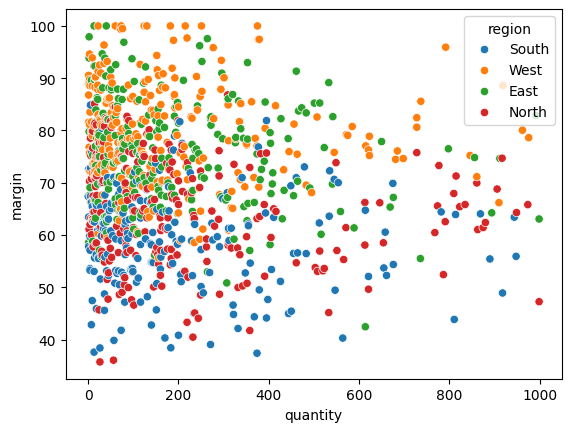

In [9]:
import seaborn as sns 
sns.scatterplot(data=t, x='quantity', y='margin', hue='region')